In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras-multi-head
!pip install keras-self-attention

In [3]:
import keras 
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

import numpy as np
import os
import sys

import wave
import copy
import math

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Input, Flatten, Embedding, Convolution1D, Dropout, GRU, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence


In [ ]:
%cd /content/drive/MyDrive/PROJECT/codes


In [5]:
from features import *
from helper import *

In [6]:
#code_path = os.path.dirname(os.path.realpath(os.getcwd()))
code_path = "/content/drive/MyDrive/PROJECT/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000


In [7]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [8]:
text = []

for ses_mod in data2:
    text.append(ses_mod['transcription'])

In [9]:
MAX_SEQUENCE_LENGTH = 500

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

token_tr_X = tokenizer.texts_to_sequences(text)
x_train_text = []

x_train_text = sequence.pad_sequences(token_tr_X, maxlen=MAX_SEQUENCE_LENGTH)

In [10]:
import codecs
EMBEDDING_DIM = 300

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

file_loc = data_path + 'glove.42B.300d/glove.840B.300d.txt'

print (file_loc)

gembeddings_index = {}
with codecs.open(file_loc, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        gembedding = np.asarray(values[1:], dtype='float32')
        gembeddings_index[word] = gembedding
#
f.close()
print('G Word embeddings:', len(gembeddings_index))

nb_words = len(word_index) +1
g_word_embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    gembedding_vector = gembeddings_index.get(word)
    if gembedding_vector is not None:
        g_word_embedding_matrix[i] = gembedding_vector
        
print('G Null word embeddings: %d' % np.sum(np.sum(g_word_embedding_matrix, axis=1) == 0))

Found 2736 unique tokens
/content/drive/MyDrive/FINAL THESIS PROJECT/data/glove.42B.300d/glove.840B.300d.txt
G Word embeddings: 2196017
G Null word embeddings: 100


In [11]:
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
    
Y = label_binarize(Y,emotions_used)

Y.shape

(4936, 4)

In [12]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [13]:
xtrain_tx = x_train_text[:3838]
xtest_tx = x_train_text[3838:]
ytrain_tx = Y[:3838]
ytest_tx = Y[3838:]

print(xtrain_tx.shape)
print(xtest_tx.shape)

print(ytrain_tx.shape)
print(xtest_tx.shape)

(3838, 500)
(1098, 500)
(3838, 4)
(1098, 500)


In [14]:
xtrain_tx[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [15]:
ytrain_tx[0]

array([0, 0, 1, 0])

In [16]:
ytest_tx[0]

array([0, 0, 1, 0])

#**MODEL 1**

In [17]:
model = Sequential()
model.add(Embedding(nb_words,
                    EMBEDDING_DIM,
                    weights = [g_word_embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = True))
    
model.add(GRU(1024, activation='relu', return_sequences=True))
model.add(GRU(512, activation='relu', return_sequences=True))
model.add(GRU(256, activation='relu', return_sequences=False))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

print("Model1 Built")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          821100    
_________________________________________________________________
gru (GRU)                    (None, 500, 1024)         4073472   
_________________________________________________________________
gru_1 (GRU)                  (None, 500, 512)          2362368   
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [18]:
hist = model.fit(xtrain_tx, ytrain_tx, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_split=0.2)

Epoch 1/50
31/31 [==============================] - 94s 3s/step - loss: 1.3570 - accuracy: 0.3455 - val_loss: 1.3030 - val_accuracy: 0.3568
Epoch 2/50
31/31 [==============================] - 88s 3s/step - loss: 1.1641 - accuracy: 0.4790 - val_loss: 1.1956 - val_accuracy: 0.4922
Epoch 3/50
31/31 [==============================] - 88s 3s/step - loss: 0.9047 - accuracy: 0.6298 - val_loss: 1.0578 - val_accuracy: 0.5781
Epoch 4/50
31/31 [==============================] - 88s 3s/step - loss: 0.6798 - accuracy: 0.7522 - val_loss: 1.0197 - val_accuracy: 0.6289
Epoch 5/50
31/31 [==============================] - 88s 3s/step - loss: 0.5405 - accuracy: 0.7964 - val_loss: 1.1307 - val_accuracy: 0.6081
Epoch 6/50
31/31 [==============================] - 87s 3s/step - loss: 0.4353 - accuracy: 0.8331 - val_loss: 1.1916 - val_accuracy: 0.6198
Epoch 7/50
31/31 [==============================] - 87s 3s/step - loss: 0.3772 - accuracy: 0.8574 - val_loss: 1.4289 - val_accuracy: 0.5742
Epoch 8/50
31/31 [==

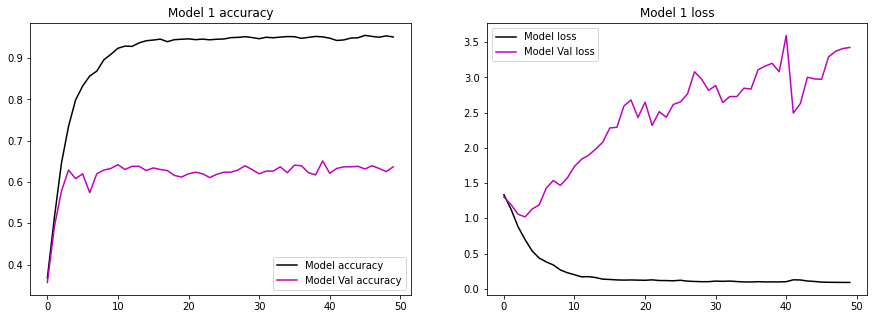

In [19]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [20]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics
import itertools

In [21]:
loss, acc = model.evaluate(xtrain_tx, ytrain_tx,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_tx, ytest_tx,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.75402 and Training Accuracy 89.16%
Validation Loss 3.70360 and Validation Accuracy 60.02%


In [22]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_tx, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.92      0.89      0.90       933
         exc       0.90      0.88      0.89       742
         neu       0.92      0.85      0.88      1324
         sad       0.90      0.92      0.91       839

   micro avg       0.91      0.88      0.89      3838
   macro avg       0.91      0.88      0.89      3838
weighted avg       0.91      0.88      0.89      3838
 samples avg       0.88      0.88      0.88      3838



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_tx, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.58      0.74      0.65       170
         exc       0.73      0.54      0.62       299
         neu       0.61      0.56      0.58       384
         sad       0.59      0.61      0.60       245

   micro avg       0.62      0.59      0.61      1098
   macro avg       0.63      0.61      0.61      1098
weighted avg       0.63      0.59      0.61      1098
 samples avg       0.59      0.59      0.59      1098



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.74 0.01 0.12 0.14]
 [0.08 0.54 0.25 0.13]
 [0.15 0.11 0.57 0.17]
 [0.07 0.07 0.22 0.63]]


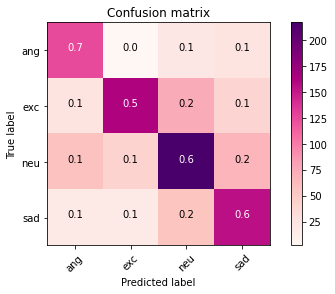

In [25]:
import itertools
Y_pred = model.predict(xtest_tx)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_tx,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL 2**

In [17]:
model2 = Sequential()
model2.add(Embedding(nb_words,
                    EMBEDDING_DIM,
                    weights = [g_word_embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = True))
    
model2.add(GRU(256, return_sequences=True))
model2.add(SeqSelfAttention(attention_activation='relu'))
model2.add(GRU(128, return_sequences=True))
model2.add(SeqSelfAttention(attention_activation='relu'))
model2.add(GRU(128, return_sequences=False))

model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dense(4))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model2.summary()

print("Model2 Built")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          821100    
_________________________________________________________________
gru (GRU)                    (None, 500, 256)          428544    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 256)         16449     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         148224    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 128)         8257      
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 256)               3

In [18]:
hist = model2.fit(xtrain_tx, ytrain_tx, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_split= 0.2)

Epoch 1/50
31/31 [==============================] - 57s 704ms/step - loss: 1.3655 - accuracy: 0.3281 - val_loss: 1.4033 - val_accuracy: 0.3086
Epoch 2/50
31/31 [==============================] - 20s 662ms/step - loss: 1.3468 - accuracy: 0.3546 - val_loss: 1.3540 - val_accuracy: 0.3581
Epoch 3/50
31/31 [==============================] - 21s 665ms/step - loss: 1.2294 - accuracy: 0.4638 - val_loss: 1.1786 - val_accuracy: 0.5013
Epoch 4/50
31/31 [==============================] - 21s 669ms/step - loss: 0.9895 - accuracy: 0.5964 - val_loss: 1.1463 - val_accuracy: 0.5768
Epoch 5/50
31/31 [==============================] - 21s 672ms/step - loss: 0.8267 - accuracy: 0.6823 - val_loss: 1.1494 - val_accuracy: 0.5820
Epoch 6/50
31/31 [==============================] - 21s 677ms/step - loss: 0.6368 - accuracy: 0.7632 - val_loss: 1.1298 - val_accuracy: 0.5911
Epoch 7/50
31/31 [==============================] - 21s 680ms/step - loss: 0.5201 - accuracy: 0.8032 - val_loss: 1.2226 - val_accuracy: 0.6107

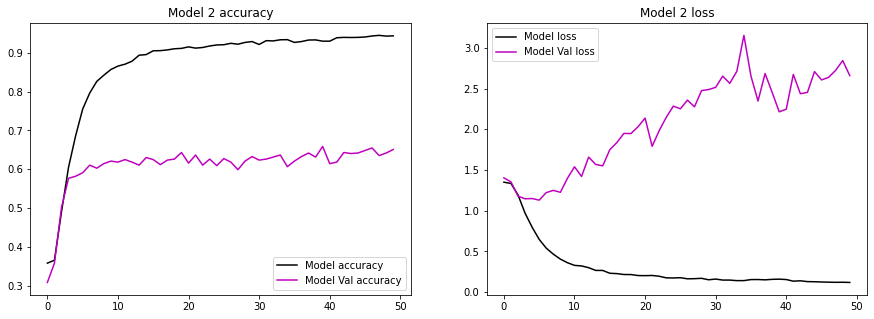

In [19]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 2 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 2 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [20]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [21]:
loss, acc = model2.evaluate(xtrain_tx, ytrain_tx,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model2.evaluate(xtest_tx, ytest_tx,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.61921 and Training Accuracy 89.00%
Validation Loss 2.77912 and Validation Accuracy 61.84%


In [22]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 2")
pred = model2.predict(xtrain_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_tx, labels, target_names = emotions_used))

model 2
              precision    recall  f1-score   support

         ang       0.93      0.88      0.91       933
         exc       0.90      0.88      0.89       742
         neu       0.88      0.87      0.87      1324
         sad       0.93      0.87      0.90       839

   micro avg       0.90      0.87      0.89      3838
   macro avg       0.91      0.88      0.89      3838
weighted avg       0.91      0.87      0.89      3838
 samples avg       0.87      0.87      0.87      3838



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# CR untuk Validation Data
print("model 2")
pred = model2.predict(xtest_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_tx, labels, target_names = emotions_used))

model 2
              precision    recall  f1-score   support

         ang       0.61      0.78      0.69       170
         exc       0.71      0.55      0.62       299
         neu       0.58      0.59      0.58       384
         sad       0.65      0.56      0.60       245

   micro avg       0.63      0.60      0.62      1098
   macro avg       0.64      0.62      0.62      1098
weighted avg       0.64      0.60      0.61      1098
 samples avg       0.60      0.60      0.60      1098



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 2
Normalized Confusion Matrix
[[0.78 0.02 0.12 0.08]
 [0.07 0.56 0.3  0.07]
 [0.14 0.12 0.63 0.11]
 [0.06 0.08 0.3  0.56]]


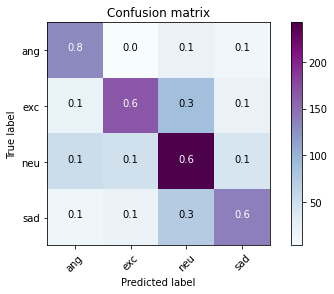

In [25]:
import itertools
Y_pred = model2.predict(xtest_tx)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_tx,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 2")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL 3**

In [17]:
model3 = Sequential()
model3.add(Embedding(nb_words,
                    EMBEDDING_DIM,
                    weights = [g_word_embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = True))
    
model3.add(Bidirectional(GRU(1024, activation="relu", return_sequences=True)))
model3.add(Bidirectional(GRU(256, activation='relu', return_sequences=True)))
model3.add(Bidirectional(GRU(128)))

model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dense(4))
model3.add(Activation('softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model3.summary()

print("Model3 Built")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          821100    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 2048)         8146944   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 512)          3542016   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               493056    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [ ]:
hist = model3.fit(xtrain_tx, ytrain_tx, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_split=0.2)

Epoch 1/50
31/31 [==============================] - 157s 4s/step - loss: 1.3389 - accuracy: 0.3576 - val_loss: 1.1911 - val_accuracy: 0.4414
Epoch 2/50
31/31 [==============================] - 120s 4s/step - loss: 1.0492 - accuracy: 0.5485 - val_loss: 1.2314 - val_accuracy: 0.4870
Epoch 3/50
31/31 [==============================] - 119s 4s/step - loss: 0.8241 - accuracy: 0.6779 - val_loss: 1.0992 - val_accuracy: 0.5977
Epoch 4/50
31/31 [==============================] - 119s 4s/step - loss: 0.6501 - accuracy: 0.7436 - val_loss: 1.1358 - val_accuracy: 0.5951
Epoch 5/50
31/31 [==============================] - 120s 4s/step - loss: 0.4965 - accuracy: 0.8170 - val_loss: 1.1413 - val_accuracy: 0.6016
Epoch 6/50
31/31 [==============================] - 119s 4s/step - loss: 0.4081 - accuracy: 0.8421 - val_loss: 1.3188 - val_accuracy: 0.6289
Epoch 7/50
31/31 [==============================] - 124s 4s/step - loss: 0.3416 - accuracy: 0.8549 - val_loss: 1.3809 - val_accuracy: 0.6263
Epoch 8/50
31

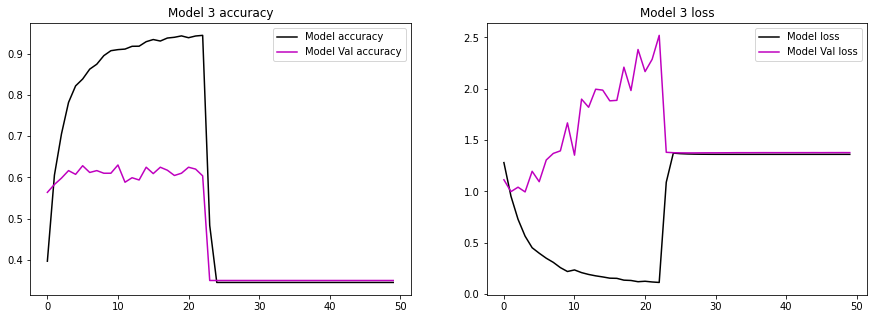

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 3 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 3 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model3.evaluate(xtrain_tx, ytrain_tx,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model3.evaluate(xtest_tx, ytest_tx,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.36106 and Training Accuracy 34.50%
Validation Loss 1.37786 and Validation Accuracy 34.97%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 3")
pred = model3.predict(xtrain_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_tx, labels, target_names = emotions_used))

model 3
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       933
         exc       0.00      0.00      0.00       742
         neu       0.00      0.00      0.00      1324
         sad       0.00      0.00      0.00       839

   micro avg       0.00      0.00      0.00      3838
   macro avg       0.00      0.00      0.00      3838
weighted avg       0.00      0.00      0.00      3838
 samples avg       0.00      0.00      0.00      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 3")
pred = model3.predict(xtest_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_tx, labels, target_names = emotions_used))

model 3
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       170
         exc       0.00      0.00      0.00       299
         neu       0.00      0.00      0.00       384
         sad       0.00      0.00      0.00       245

   micro avg       0.00      0.00      0.00      1098
   macro avg       0.00      0.00      0.00      1098
weighted avg       0.00      0.00      0.00      1098
 samples avg       0.00      0.00      0.00      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 3
Normalized Confusion Matrix
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


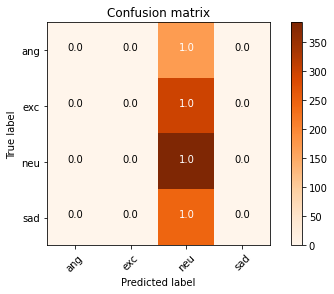

In [ ]:
import itertools
Y_pred = model3.predict(xtest_tx)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_tx,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 3")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL 4**

In [17]:
model4 = Sequential()
model4.add(Embedding(nb_words,
                    EMBEDDING_DIM,
                    weights = [g_word_embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = True))
    
model4.add(Bidirectional(GRU(128, activation="relu", return_sequences=True)))
model4.add(SeqSelfAttention(attention_activation="relu"))
model4.add(Bidirectional(GRU(128, activation='relu', return_sequences=True)))
model4.add(SeqSelfAttention(attention_activation="relu"))
model4.add(Bidirectional(GRU(128, activation='relu', return_sequences=False)))
model4.add(Dropout(0.1))

model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dense(4))
model4.add(Activation('softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model4.summary()

print("Model4 Built")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          821100    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          330240    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 256)         16449     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         296448    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [18]:
hist = model4.fit(xtrain_tx, ytrain_tx, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_split=0.2)

Epoch 1/50
31/31 [==============================] - 202s 6s/step - loss: 1.3683 - accuracy: 0.3701 - val_loss: 1.4142 - val_accuracy: 0.2760
Epoch 2/50
31/31 [==============================] - 189s 6s/step - loss: 1.3476 - accuracy: 0.3635 - val_loss: 1.4190 - val_accuracy: 0.2760
Epoch 3/50
31/31 [==============================] - 187s 6s/step - loss: 1.3074 - accuracy: 0.3882 - val_loss: 1.3496 - val_accuracy: 0.3581
Epoch 4/50
31/31 [==============================] - 185s 6s/step - loss: 1.1864 - accuracy: 0.4420 - val_loss: 1.4663 - val_accuracy: 0.3776
Epoch 5/50
31/31 [==============================] - 182s 6s/step - loss: 1.0184 - accuracy: 0.5226 - val_loss: 1.3228 - val_accuracy: 0.4779
Epoch 6/50
31/31 [==============================] - 182s 6s/step - loss: 0.9914 - accuracy: 0.5479 - val_loss: 1.3976 - val_accuracy: 0.4727
Epoch 7/50
31/31 [==============================] - 178s 6s/step - loss: 0.9079 - accuracy: 0.5907 - val_loss: 1.3302 - val_accuracy: 0.4883
Epoch 8/50
31

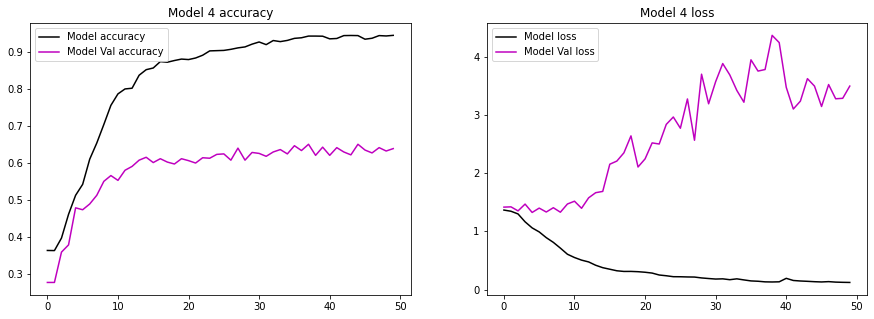

In [19]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 4 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 4 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [22]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [20]:
loss, acc = model4.evaluate(xtrain_tx, ytrain_tx,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model4.evaluate(xtest_tx, ytest_tx,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.78567 and Training Accuracy 88.67%
Validation Loss 3.77614 and Validation Accuracy 61.66%


In [23]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 4")
pred = model4.predict(xtrain_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_tx, labels, target_names = emotions_used))

model 4
              precision    recall  f1-score   support

         ang       0.94      0.85      0.90       933
         exc       0.91      0.86      0.89       742
         neu       0.89      0.87      0.88      1324
         sad       0.89      0.90      0.90       839

   micro avg       0.91      0.87      0.89      3838
   macro avg       0.91      0.87      0.89      3838
weighted avg       0.91      0.87      0.89      3838
 samples avg       0.87      0.87      0.87      3838



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# CR untuk Validation Data
print("model 4")
pred = model4.predict(xtest_tx)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_tx, labels, target_names = emotions_used))

model 4
              precision    recall  f1-score   support

         ang       0.68      0.66      0.67       170
         exc       0.74      0.54      0.63       299
         neu       0.61      0.60      0.61       384
         sad       0.57      0.64      0.60       245

   micro avg       0.64      0.60      0.62      1098
   macro avg       0.65      0.61      0.63      1098
weighted avg       0.65      0.60      0.62      1098
 samples avg       0.60      0.60      0.60      1098



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 4
Normalized Confusion Matrix
[[0.67 0.05 0.16 0.12]
 [0.05 0.55 0.26 0.14]
 [0.08 0.1  0.62 0.21]
 [0.03 0.06 0.24 0.67]]


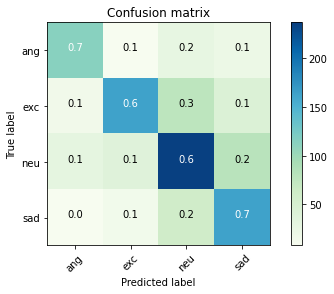

In [26]:
import itertools
Y_pred = model4.predict(xtest_tx)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_tx,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 4")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 